# OSV5M Dataset Showcase

This notebook demonstrates the OpenStreetView-5M (OSV5M) dataset for visual geolocation tasks.

## Overview
- **210,122** test samples of street view images from around the world
- Coverage: **219 countries**, **2,364 regions**, **26,355 cities**
- Each sample includes street view image + precise geographic metadata

In [11]:
%pip install folium
# Setup and imports
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Dict, List, Tuple
import json

print("Setup complete!")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Setup complete!


## 1. Load Dataset Metadata

In [12]:
# Load OSV5M dataset metadata
cache_dir = Path.home() / ".cache/huggingface/datasets/osv5m"
test_csv = cache_dir / "test.csv"

if not test_csv.exists():
    print("Dataset not found. It will be downloaded when you first run the environment.")
    print(f"Expected location: {test_csv}")
else:
    # Load the dataset
    df = pd.read_csv(test_csv, dtype={"id": str})
    print(f"✓ Loaded {len(df):,} samples from OSV5M test set")
    print(f"\nDataset columns:")
    for col in df.columns:
        print(f"  • {col}")

✓ Loaded 210,122 samples from OSV5M test set

Dataset columns:
  • id
  • latitude
  • longitude
  • thumb_original_url
  • country
  • sequence
  • captured_at
  • lon_bin
  • lat_bin
  • cell
  • land_cover
  • road_index
  • drive_side
  • climate
  • soil
  • dist_sea
  • region
  • sub-region
  • city
  • unique_city
  • unique_sub-region
  • unique_region
  • unique_country
  • quadtree_10_1000
  • creator_username
  • creator_id


## 2. Dataset Statistics

In [13]:
# Basic statistics
print("📊 Dataset Statistics\n" + "="*50)

# Unique counts
print(f"\n🌍 Geographic Coverage:")
print(f"  • Countries: {df['country'].nunique():,}")
print(f"  • Regions: {df['region'].nunique():,}")
print(f"  • Cities: {df['city'].nunique():,}")

# Coordinate ranges
print(f"\n📍 Coordinate Ranges:")
print(f"  • Latitude: [{df['latitude'].min():.2f}°, {df['latitude'].max():.2f}°]")
print(f"  • Longitude: [{df['longitude'].min():.2f}°, {df['longitude'].max():.2f}°]")

# Missing values
print(f"\n❓ Data Completeness:")
for col in ['country', 'region', 'city', 'sub-region']:
    missing = df[col].isna().sum()
    complete_pct = (1 - missing/len(df)) * 100
    print(f"  • {col}: {complete_pct:.1f}% complete")

📊 Dataset Statistics

🌍 Geographic Coverage:
  • Countries: 219
  • Regions: 2,364
  • Cities: 26,355

📍 Coordinate Ranges:
  • Latitude: [-54.87°, 78.33°]
  • Longitude: [-176.79°, 178.62°]

❓ Data Completeness:
  • country: 100.0% complete
  • region: 99.2% complete
  • city: 100.0% complete
  • sub-region: 46.8% complete


## 3. Geographic Distribution

In [ ]:
# Display 1000 sample entries with geographic data
print("📋 1000 SAMPLE ENTRIES WITH COMPLETE GEOGRAPHIC DATA")
print("="*100)

# Select 1000 random samples with a fixed seed for reproducibility
sample_1k = df.sample(n=min(1000, len(df)), random_state=42)

# Create a cleaned display dataframe
display_cols = ['id', 'city', 'region', 'country', 'latitude', 'longitude']
display_df = sample_1k[display_cols].copy()

# Add analysis columns
display_df['city_length'] = display_df['city'].astype(str).str.len()
display_df['has_diacritics'] = display_df['city'].apply(lambda x: has_diacritics(x) if pd.notna(x) else False)
display_df['region_prefix'] = display_df['region'].apply(lambda x: str(x)[:4] if pd.notna(x) and len(str(x)) >= 4 else '')

print(f"\n📊 Summary of 1000 samples:")
print(f"  • Total samples: {len(display_df)}")
print(f"  • Unique countries: {display_df['country'].nunique()}")
print(f"  • Unique regions: {display_df['region'].nunique()}")
print(f"  • Unique cities: {display_df['city'].nunique()}")
print(f"  • Cities with diacritics: {display_df['has_diacritics'].sum()} ({display_df['has_diacritics'].mean()*100:.1f}%)")

print("\n🌍 Country distribution in sample:")
country_dist = display_df['country'].value_counts().head(20)
for country, count in country_dist.items():
    print(f"  • {country}: {count} ({count/10:.1f}%)")

print("\n📍 Coordinate spread:")
print(f"  • Latitude range: [{display_df['latitude'].min():.4f}, {display_df['latitude'].max():.4f}]")
print(f"  • Longitude range: [{display_df['longitude'].min():.4f}, {display_df['longitude'].max():.4f}]")

# Show first 50 entries in detail
print("\n\n🔍 FIRST 50 ENTRIES (DETAILED VIEW)")
print("-"*100)

# Format for better display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

formatted_df = display_df.head(50)[['city', 'region', 'country', 'latitude', 'longitude', 'has_diacritics']]
formatted_df['coordinates'] = formatted_df.apply(lambda x: f"({x['latitude']:.4f}, {x['longitude']:.4f})", axis=1)

print("\n")
for idx, row in formatted_df.iterrows():
    diacritic_marker = "✓" if row['has_diacritics'] else " "
    print(f"{idx:6d} | {row['city'][:25]:<25} | {row['region'][:25]:<25} | {row['country']:<3} | {row['coordinates']:<25} | Diac: {diacritic_marker}")

# Export to CSV for further analysis
print("\n\n💾 EXPORTING FULL 1000-SAMPLE DATASET")
print("-"*50)

output_path = "osv5m_1k_sample_analysis.csv"
sample_1k.to_csv(output_path, index=False)
print(f"✓ Full 1000-sample dataset exported to: {output_path}")
print(f"  • File contains all {len(sample_1k.columns)} original columns")
print(f"  • Use this file for detailed offline analysis")

# Show some interesting patterns found
print("\n\n🎯 INTERESTING PATTERNS IN THE SAMPLE")
print("-"*50)

# Cities with longest names
longest_cities = display_df.nlargest(10, 'city_length')[['city', 'country', 'city_length']]
print("\n📏 Longest city names:")
for _, row in longest_cities.iterrows():
    print(f"  • {row['city']} ({row['country']}): {row['city_length']} chars")

# Most common city names
common_cities = display_df['city'].value_counts().head(10)
if len(common_cities) > 0:
    print("\n🏘️ Most common city names in sample:")
    for city, count in common_cities.items():
        if count > 1:
            countries = display_df[display_df['city'] == city]['country'].unique()
            print(f"  • {city}: {count} occurrences in {', '.join(countries)}")

# Geographic extremes
print("\n🧭 Geographic extremes in sample:")
northernmost = display_df.nlargest(1, 'latitude').iloc[0]
southernmost = display_df.nsmallest(1, 'latitude').iloc[0]
easternmost = display_df.nlargest(1, 'longitude').iloc[0]
westernmost = display_df.nsmallest(1, 'longitude').iloc[0]

print(f"  • Northernmost: {northernmost['city']}, {northernmost['country']} ({northernmost['latitude']:.4f}°N)")
print(f"  • Southernmost: {southernmost['city']}, {southernmost['country']} ({southernmost['latitude']:.4f}°S)")
print(f"  • Easternmost: {easternmost['city']}, {easternmost['country']} ({easternmost['longitude']:.4f}°E)")
print(f"  • Westernmost: {westernmost['city']}, {westernmost['country']} ({westernmost['longitude']:.4f}°W)")

print("\n" + "="*100)
print("Sample analysis complete!")

In [ ]:
# Comprehensive Analysis of Geographic Naming Patterns
import unicodedata
import re
from collections import Counter

print("📊 GEOGRAPHIC NAMING PATTERNS ANALYSIS")
print("="*80)

# Helper function to detect diacritics
def has_diacritics(text):
    if pd.isna(text):
        return False
    normalized = unicodedata.normalize('NFD', str(text))
    return any(unicodedata.category(char) == 'Mn' for char in normalized)

def get_diacritic_chars(text):
    if pd.isna(text):
        return set()
    chars = set()
    for char in str(text):
        if unicodedata.category(unicodedata.normalize('NFD', char)[0]) != 'Ll' and \
           unicodedata.category(unicodedata.normalize('NFD', char)[0]) != 'Lu':
            normalized = unicodedata.normalize('NFD', char)
            if len(normalized) > 1:
                chars.add(char)
    return chars

# Analyze diacritics
print("\n🔤 DIACRITIC ANALYSIS")
print("-"*50)

for field in ['city', 'region', 'country']:
    with_diacritics = df[field].apply(has_diacritics).sum()
    total = df[field].notna().sum()
    percentage = (with_diacritics / total * 100) if total > 0 else 0
    
    print(f"\n{field.upper()}:")
    print(f"  • With diacritics: {with_diacritics:,} / {total:,} ({percentage:.2f}%)")
    
    # Find most common entries with diacritics
    diacritic_entries = df[df[field].apply(has_diacritics)][field].value_counts().head(10)
    if len(diacritic_entries) > 0:
        print(f"  • Top entries with diacritics:")
        for entry, count in diacritic_entries.items():
            print(f"    - {entry}: {count} occurrences")

# Analyze case patterns
print("\n\n📏 CASE PATTERN ANALYSIS")
print("-"*50)

def get_case_pattern(text):
    if pd.isna(text):
        return 'missing'
    text = str(text)
    if text.isupper():
        return 'UPPER'
    elif text.islower():
        return 'lower'
    elif text[0].isupper() if text else False:
        return 'Title'
    else:
        return 'mixed'

for field in ['city', 'region', 'country']:
    case_patterns = df[field].apply(get_case_pattern).value_counts()
    print(f"\n{field.upper()} case patterns:")
    for pattern, count in case_patterns.items():
        percentage = count / len(df) * 100
        print(f"  • {pattern}: {count:,} ({percentage:.2f}%)")

# Analyze common prefixes
print("\n\n🔍 COMMON PREFIX ANALYSIS")
print("-"*50)

def get_prefix(text, length=4):
    if pd.isna(text) or len(str(text)) < length:
        return None
    return str(text)[:length].lower()

for field in ['city', 'region']:
    prefixes = df[field].apply(lambda x: get_prefix(x, 4))
    prefix_counts = prefixes.value_counts().head(20)
    
    print(f"\n{field.upper()} - Top 20 prefixes (4 chars):")
    for prefix, count in prefix_counts.items():
        if prefix:
            # Find examples
            examples = df[df[field].apply(lambda x: str(x)[:4].lower() if pd.notna(x) and len(str(x)) >= 4 else None) == prefix][field].unique()[:3]
            examples_str = ', '.join(str(e) for e in examples)
            print(f"  • '{prefix}': {count:,} occurrences - Examples: {examples_str}")

# Look for specific common prefixes
print("\n\n🏷️ SPECIFIC PREFIX PATTERNS")
print("-"*50)

common_prefixes = {
    'city': ['Saint', 'San ', 'Santa', 'New ', 'Port', 'Fort', 'Mount', 'Lake', 'North', 'South', 'East', 'West', 'Upper', 'Lower'],
    'region': ['Province', 'Provincia', 'State of', 'Canton', 'District', 'County', 'Oblast', 'Prefecture']
}

for field, prefixes in common_prefixes.items():
    print(f"\n{field.upper()} - Known prefix patterns:")
    for prefix in prefixes:
        count = df[field].apply(lambda x: str(x).startswith(prefix) if pd.notna(x) else False).sum()
        if count > 0:
            percentage = count / df[field].notna().sum() * 100
            print(f"  • '{prefix}': {count:,} ({percentage:.2f}%)")
            # Show examples
            examples = df[df[field].apply(lambda x: str(x).startswith(prefix) if pd.notna(x) else False)][field].unique()[:5]
            print(f"    Examples: {', '.join(str(e) for e in examples)}")

# Statistical summary
print("\n\n📈 GENERAL STATISTICS")
print("-"*50)

print("\nLength statistics:")
for field in ['city', 'region', 'country']:
    lengths = df[field].dropna().astype(str).str.len()
    print(f"\n{field.upper()}:")
    print(f"  • Mean length: {lengths.mean():.1f} chars")
    print(f"  • Median length: {lengths.median():.0f} chars")
    print(f"  • Min/Max: {lengths.min():.0f} / {lengths.max():.0f} chars")
    print(f"  • Std Dev: {lengths.std():.2f}")

print("\n\nCoordinate statistics:")
print(f"  • Latitude range: [{df['latitude'].min():.6f}, {df['latitude'].max():.6f}]")
print(f"  • Longitude range: [{df['longitude'].min():.6f}, {df['longitude'].max():.6f}]")
print(f"  • Mean coordinates: ({df['latitude'].mean():.4f}, {df['longitude'].mean():.4f})")
print(f"  • Median coordinates: ({df['latitude'].median():.4f}, {df['longitude'].median():.4f})")

# Character set analysis
print("\n\n🌐 CHARACTER SET ANALYSIS")
print("-"*50)

def get_unique_chars(series):
    all_chars = set()
    for text in series.dropna():
        all_chars.update(set(str(text)))
    return all_chars

for field in ['city', 'region']:
    chars = get_unique_chars(df[field].head(10000))  # Sample for performance
    
    # Categorize characters
    ascii_chars = {c for c in chars if ord(c) < 128}
    extended_latin = {c for c in chars if 128 <= ord(c) < 256}
    other_chars = {c for c in chars if ord(c) >= 256}
    
    print(f"\n{field.upper()} character sets (first 10k samples):")
    print(f"  • ASCII characters: {len(ascii_chars)}")
    print(f"  • Extended Latin: {len(extended_latin)}")
    print(f"  • Other Unicode: {len(other_chars)}")
    
    if other_chars:
        sample_other = list(other_chars)[:20]
        print(f"    Sample non-Latin chars: {' '.join(sample_other)}")

print("\n" + "="*80)
print("Analysis complete!")

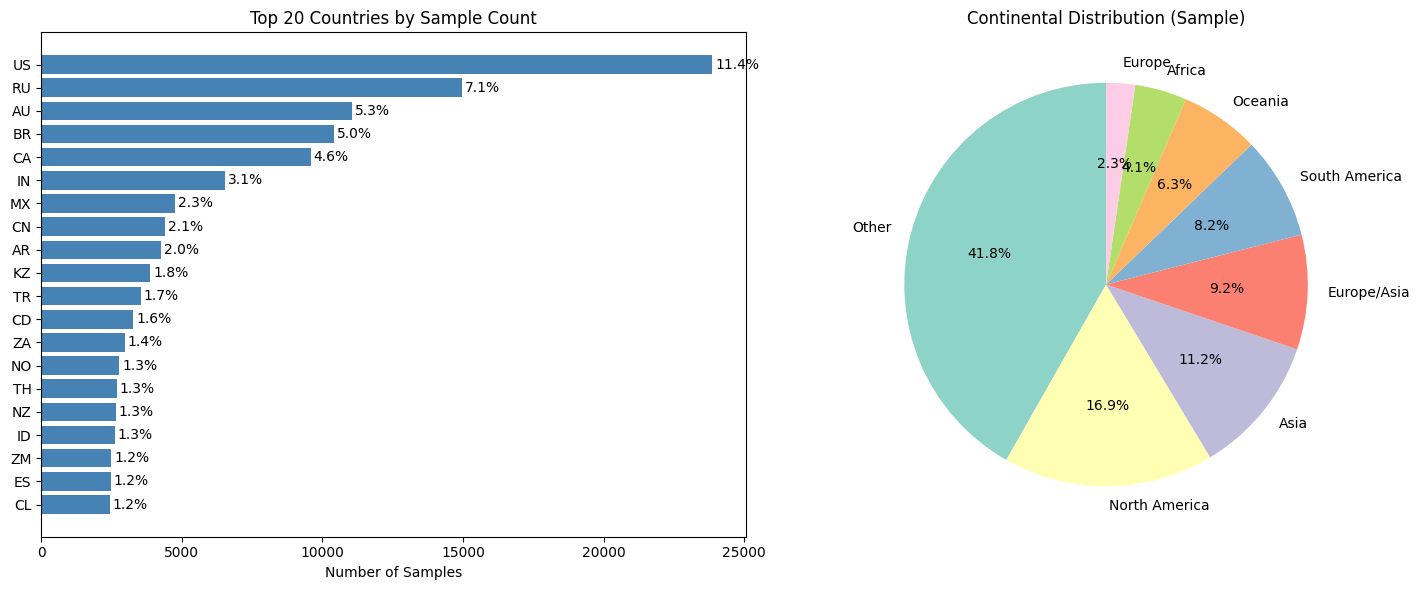

In [14]:
# Top countries visualization
top_countries = df['country'].value_counts().head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of top countries
ax1.barh(range(len(top_countries)), top_countries.values, color='steelblue')
ax1.set_yticks(range(len(top_countries)))
ax1.set_yticklabels(top_countries.index)
ax1.set_xlabel('Number of Samples')
ax1.set_title('Top 20 Countries by Sample Count')
ax1.invert_yaxis()

# Add percentage labels
for i, (country, count) in enumerate(top_countries.items()):
    pct = count / len(df) * 100
    ax1.text(count + 100, i, f'{pct:.1f}%', va='center')

# Pie chart of regional distribution (continents approximation)
continent_mapping = {
    'US': 'North America', 'CA': 'North America', 'MX': 'North America',
    'BR': 'South America', 'AR': 'South America', 'CL': 'South America',
    'RU': 'Europe/Asia', 'TR': 'Europe/Asia', 'KZ': 'Asia', 'CN': 'Asia',
    'IN': 'Asia', 'TH': 'Asia', 'ID': 'Asia', 'JP': 'Asia',
    'AU': 'Oceania', 'NZ': 'Oceania',
    'ZA': 'Africa', 'CD': 'Africa', 'ZM': 'Africa',
    'NO': 'Europe', 'ES': 'Europe'
}

df_sample = df.head(10000)  # Use sample for speed
continents = df_sample['country'].map(continent_mapping).fillna('Other')
continent_counts = continents.value_counts()

ax2.pie(continent_counts.values, labels=continent_counts.index, autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Set3.colors)
ax2.set_title('Continental Distribution (Sample)')

plt.tight_layout()
plt.show()

## 4. Sample Images with Metadata

### 4a. Enhanced Image Grid with Key Metadata

In [15]:
# Find available images
images_dir = cache_dir / "images" / "test"
available_samples = []

if images_dir.exists():
    # Check for available images - randomly sample from the dataset
    import random
    
    # Get a random sample of rows to check
    sample_rows = df.sample(n=min(20000, len(df)), random_state=42)
    
    for idx, row in sample_rows.iterrows():
        img_id = row["id"]
        img_path = images_dir / "00" / f"{img_id}.jpg"
        
        if img_path.exists():
            available_samples.append({
                'path': img_path,
                'data': row
            })
            
        if len(available_samples) >= 200:
            break
    
    print(f"Found {len(available_samples)} sample images")
else:
    print("No images found. Images will be downloaded when you first run the environment.")

Found 200 sample images


/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928966/431230828.py:44: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sdan/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu S

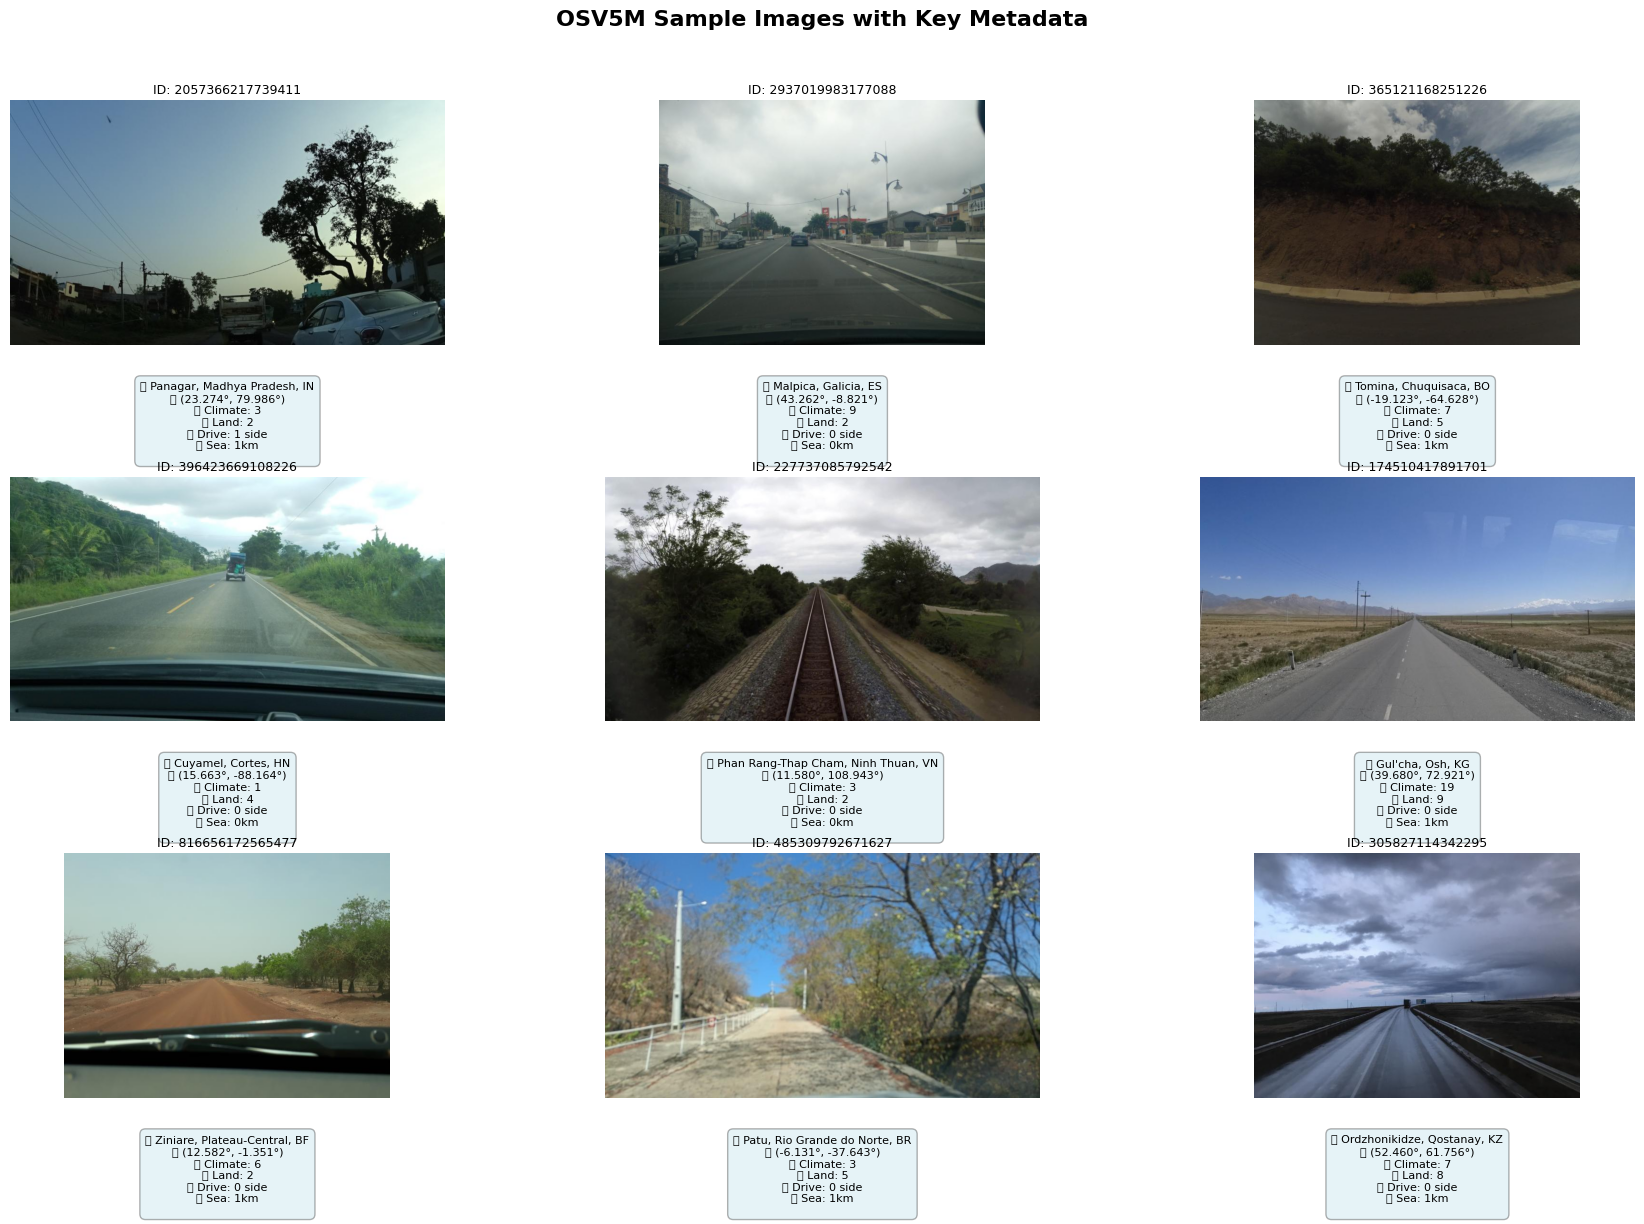

In [16]:
# Enhanced grid view with key metadata highlighted
if available_samples:
    n_cols = 3
    n_rows = min(3, (len(available_samples) + n_cols - 1) // n_cols)
    n_samples = min(9, len(available_samples))
    
    fig = plt.figure(figsize=(18, 4*n_rows))
    
    for i in range(n_samples):
        sample = available_samples[i]
        img = Image.open(sample['path'])
        data = sample['data']
        
        # Create subplot
        ax = plt.subplot(n_rows, n_cols, i+1)
        
        # Display image
        ax.imshow(img)
        ax.axis('off')
        
        # Create detailed info box below image
        info_text = f"📍 {data['city']}, {data['region']}, {data['country']}\n"
        info_text += f"🌐 ({data['latitude']:.3f}°, {data['longitude']:.3f}°)\n"
        
        # Add key environmental features
        if pd.notna(data['climate']):
            info_text += f"🌡️ Climate: {data['climate']}\n"
        if pd.notna(data['land_cover']):
            info_text += f"🌳 Land: {data['land_cover']}\n"
        if pd.notna(data['drive_side']):
            info_text += f"🚗 Drive: {data['drive_side']} side\n"
        if pd.notna(data['dist_sea']):
            info_text += f"🌊 Sea: {data['dist_sea']:.0f}km\n"
        
        # Add title with ID
        ax.set_title(f"ID: {data['id']}", fontsize=9, pad=5)
        
        # Add text box with metadata
        ax.text(0.5, -0.15, info_text, transform=ax.transAxes,
                fontsize=8, ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))
    
    plt.suptitle("OSV5M Sample Images with Key Metadata", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No images available to display")

📍 LOCATION INFORMATION
ID: 2057366217739411
City: Panagar
Region: Madhya Pradesh
Country: IN
Coordinates: (23.274160, 79.986495)

🌍 GEOGRAPHIC FEATURES
Climate: 3
Land Cover: 2
Soil Type: 3
Distance to Sea: 0.9999970070423776 km

🚗 INFRASTRUCTURE
Drive Side: 1
Road Index: 4.311433792

📊 DATASET METADATA
Captured: 1506705857000
Sequence: 0Nrt1Dlwz-lYCa2qnIfhAQ
Creator: geohacker
Creator ID: 108948641335888.0

🗺️ SPATIAL INDEXING
Lat Bin: 57
Lon Bin: 71
Cell: (71, 57)
Quadtree: 6165

🔍 UNIQUENESS FLAGS
Unique City: Panagar_Jabalpur_Madhya Pradesh_IN
Unique Sub-region: Jabalpur_Madhya Pradesh_IN
Unique Region: Madhya Pradesh_IN
Unique Country: IN

id                                                     2057366217739411
latitude                                                       23.27416
longitude                                                     79.986495
thumb_original_url    https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...
country                                                    

/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1928966/4068587093.py:72: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missin

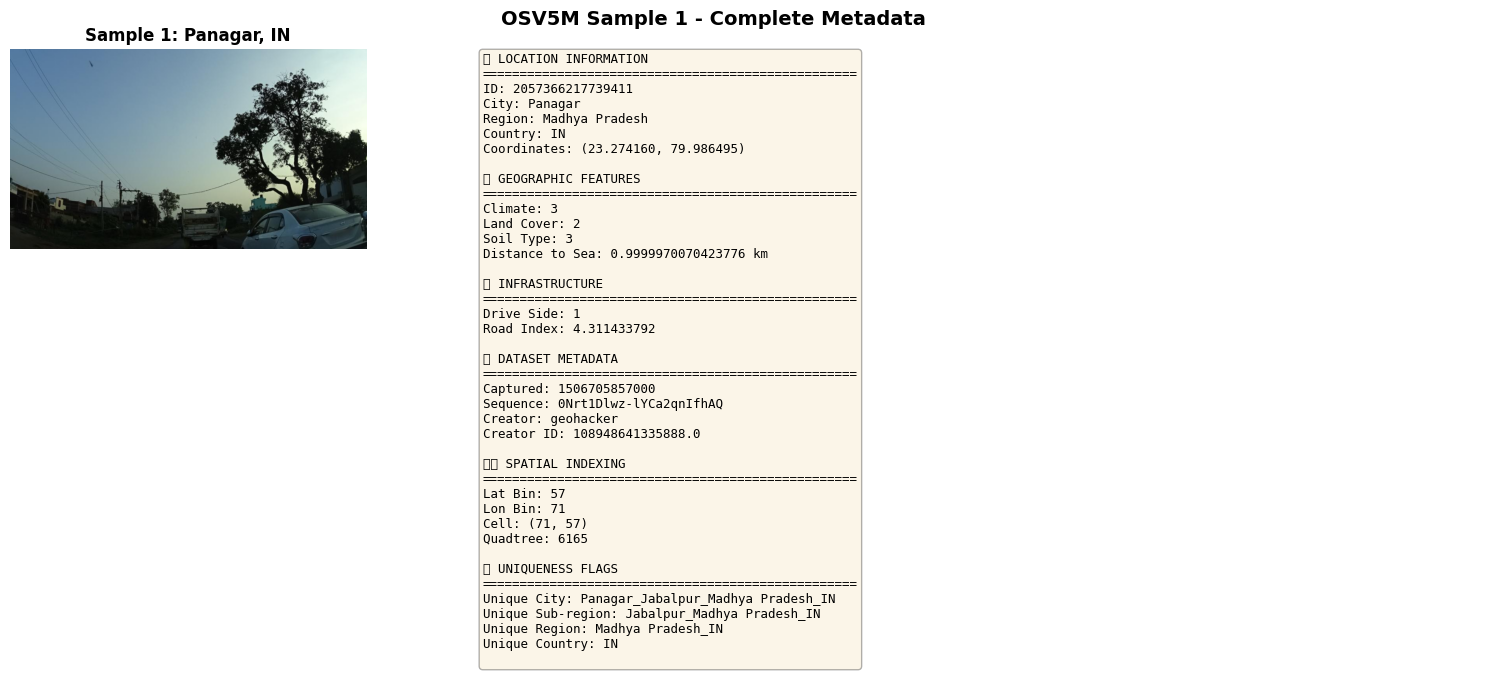


📍 LOCATION INFORMATION
ID: 2937019983177088
City: Malpica
Region: Galicia
Country: ES
Coordinates: (43.261569, -8.820610)

🌍 GEOGRAPHIC FEATURES
Climate: 9
Land Cover: 2
Soil Type: 9
Distance to Sea: 0.0723206446632676 km

🚗 INFRASTRUCTURE
Drive Side: 0
Road Index: 5.495867729

📊 DATASET METADATA
Captured: 1440100234771
Sequence: L-jY1bvnFK9Z_E_-a365zg
Creator: txenoo
Creator ID: 107308784835005.0

🗺️ SPATIAL INDEXING
Lat Bin: 72
Lon Bin: 46
Cell: (46, 72)
Quadtree: 4992

🔍 UNIQUENESS FLAGS
Unique City: Malpica_Provincia da Coruna_Galicia_ES
Unique Sub-region: Provincia da Coruna_Galicia_ES
Unique Region: Galicia_ES
Unique Country: ES

id                                                     2937019983177088
latitude                                                      43.261569
longitude                                                      -8.82061
thumb_original_url    https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...
country                                                            

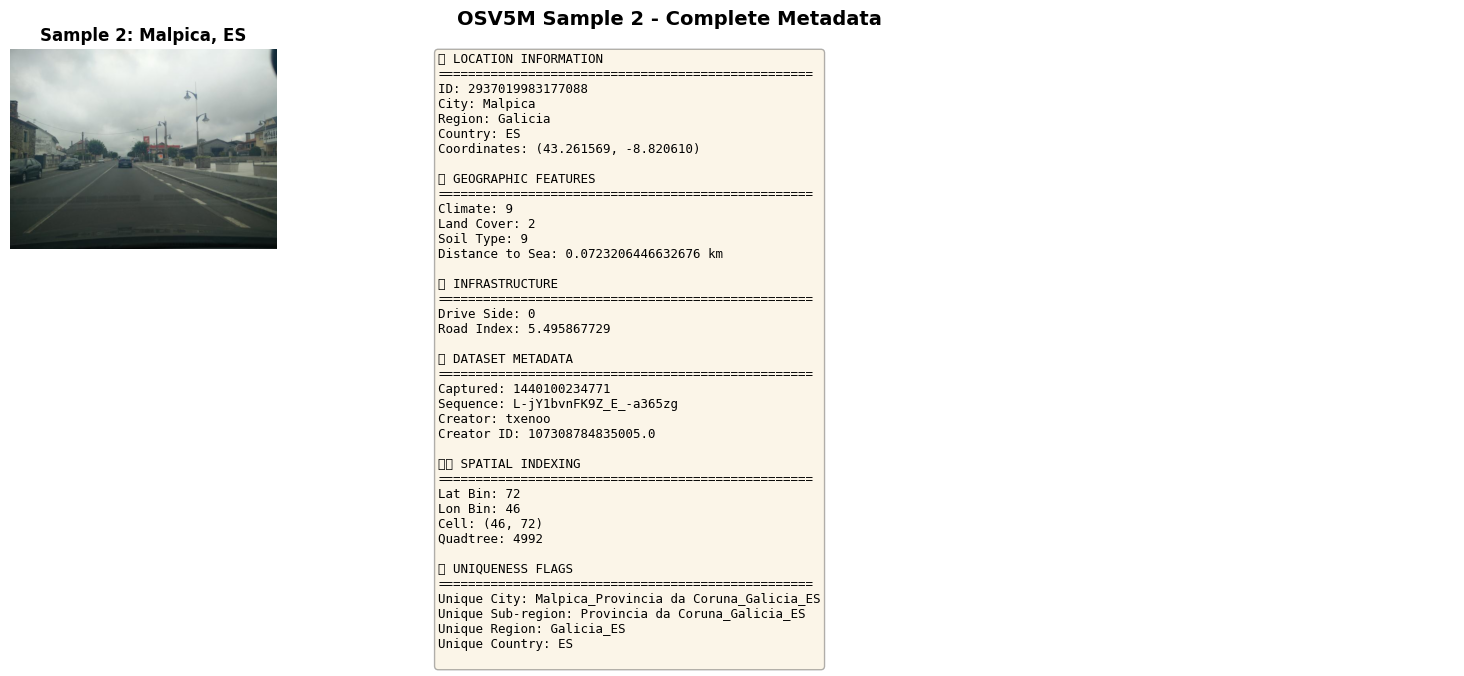


📍 LOCATION INFORMATION
ID: 365121168251226
City: Tomina
Region: Chuquisaca
Country: BO
Coordinates: (-19.123342, -64.628402)

🌍 GEOGRAPHIC FEATURES
Climate: 7
Land Cover: 5
Soil Type: 10
Distance to Sea: 0.9999994932164592 km

🚗 INFRASTRUCTURE
Drive Side: 0
Road Index: 3.114021222

📊 DATASET METADATA
Captured: 1483109568000
Sequence: vj92hqf9m0r0di3c66bcog
Creator: yoviajo
Creator ID: 107127184853389.0

🗺️ SPATIAL INDEXING
Lat Bin: 26
Lon Bin: 31
Cell: (31, 26)
Quadtree: 385

🔍 UNIQUENESS FLAGS
Unique City: Tomina_Provincia Tomina_Chuquisaca_BO
Unique Sub-region: Provincia Tomina_Chuquisaca_BO
Unique Region: Chuquisaca_BO
Unique Country: BO

id                                                      365121168251226
latitude                                                     -19.123342
longitude                                                    -64.628402
thumb_original_url    https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...
country                                                      

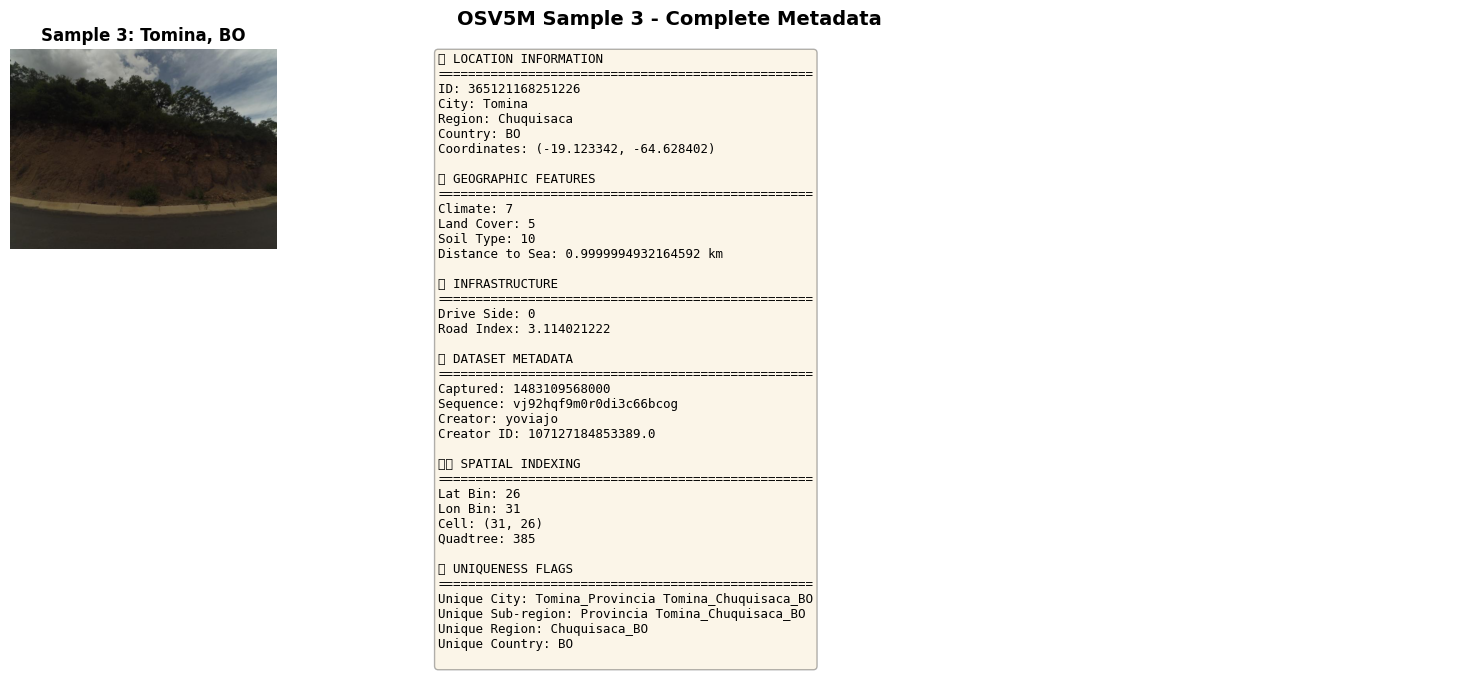


📍 LOCATION INFORMATION
ID: 396423669108226
City: Cuyamel
Region: Cortes
Country: HN
Coordinates: (15.663155, -88.163811)

🌍 GEOGRAPHIC FEATURES
Climate: 1
Land Cover: 4
Soil Type: 5
Distance to Sea: 0.0493636076542812 km

🚗 INFRASTRUCTURE
Drive Side: 0
Road Index: 3.804879904

📊 DATASET METADATA
Captured: 1655155268715
Sequence: Y2kKdImwSsjrZcLE5o6igt
Creator: Davidmejia7
Creator ID: 100703216022075.0

🗺️ SPATIAL INDEXING
Lat Bin: 52
Lon Bin: 24
Cell: (24, 52)
Quadtree: 1884

🔍 UNIQUENESS FLAGS
Unique City: Cuyamel_NaN_Cortes_HN
Unique Sub-region: N/A
Unique Region: Cortes_HN
Unique Country: HN

id                                                      396423669108226
latitude                                                      15.663155
longitude                                                    -88.163811
thumb_original_url    https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...
country                                                              HN
sequence                            

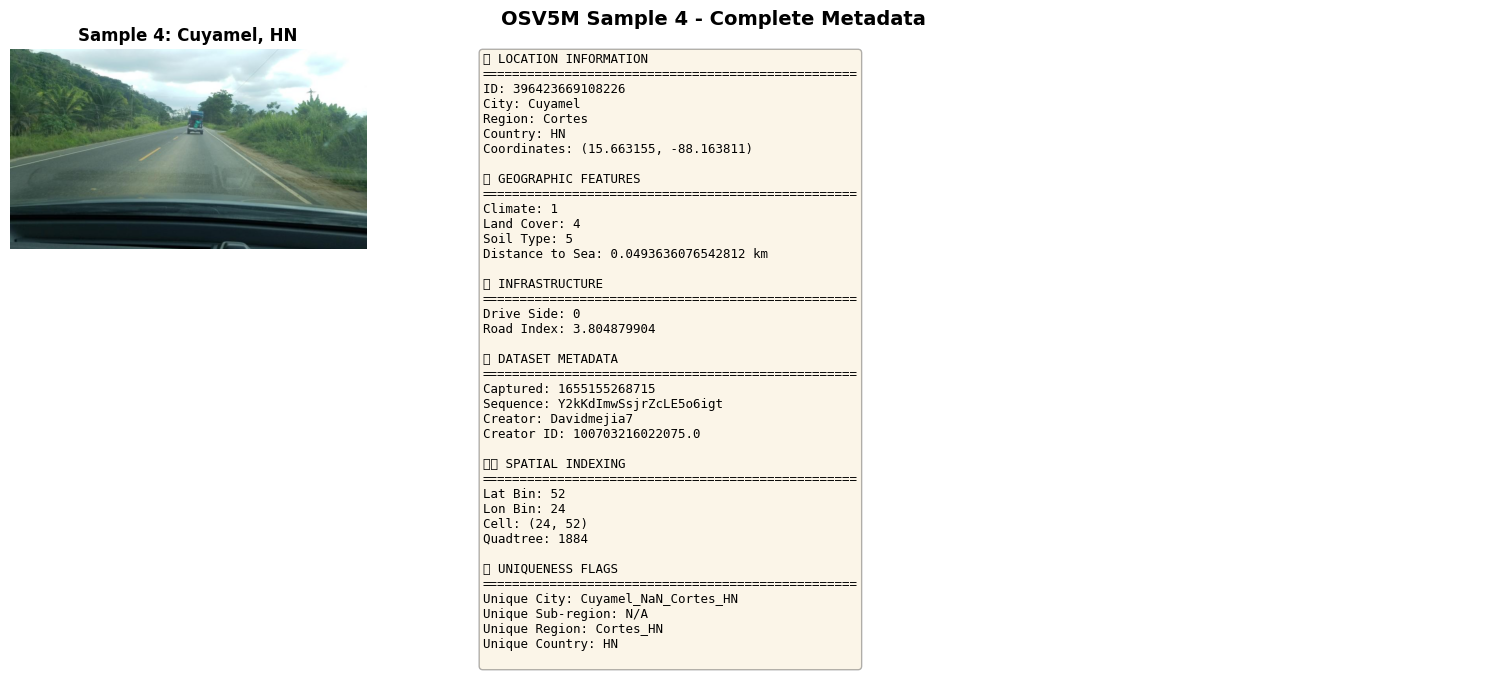


📍 LOCATION INFORMATION
ID: 227737085792542
City: Phan Rang-Thap Cham
Region: Ninh Thuan
Country: VN
Coordinates: (11.580035, 108.942887)

🌍 GEOGRAPHIC FEATURES
Climate: 3
Land Cover: 2
Soil Type: 9
Distance to Sea: 0.104606675200464 km

🚗 INFRASTRUCTURE
Drive Side: 0
Road Index: 3.370807171

📊 DATASET METADATA
Captured: 1483290291110
Sequence: XquZoWfomLkewXw15ydrbg
Creator: cut
Creator ID: 105565668345677.0

🗺️ SPATIAL INDEXING
Lat Bin: 49
Lon Bin: 79
Cell: (79, 49)
Quadtree: 1827

🔍 UNIQUENESS FLAGS
Unique City: Phan Rang-Thap Cham_NaN_Ninh Thuan_VN
Unique Sub-region: N/A
Unique Region: Ninh Thuan_VN
Unique Country: VN

id                                                      227737085792542
latitude                                                      11.580035
longitude                                                    108.942887
thumb_original_url    https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...
country                                                              VN
sequence 

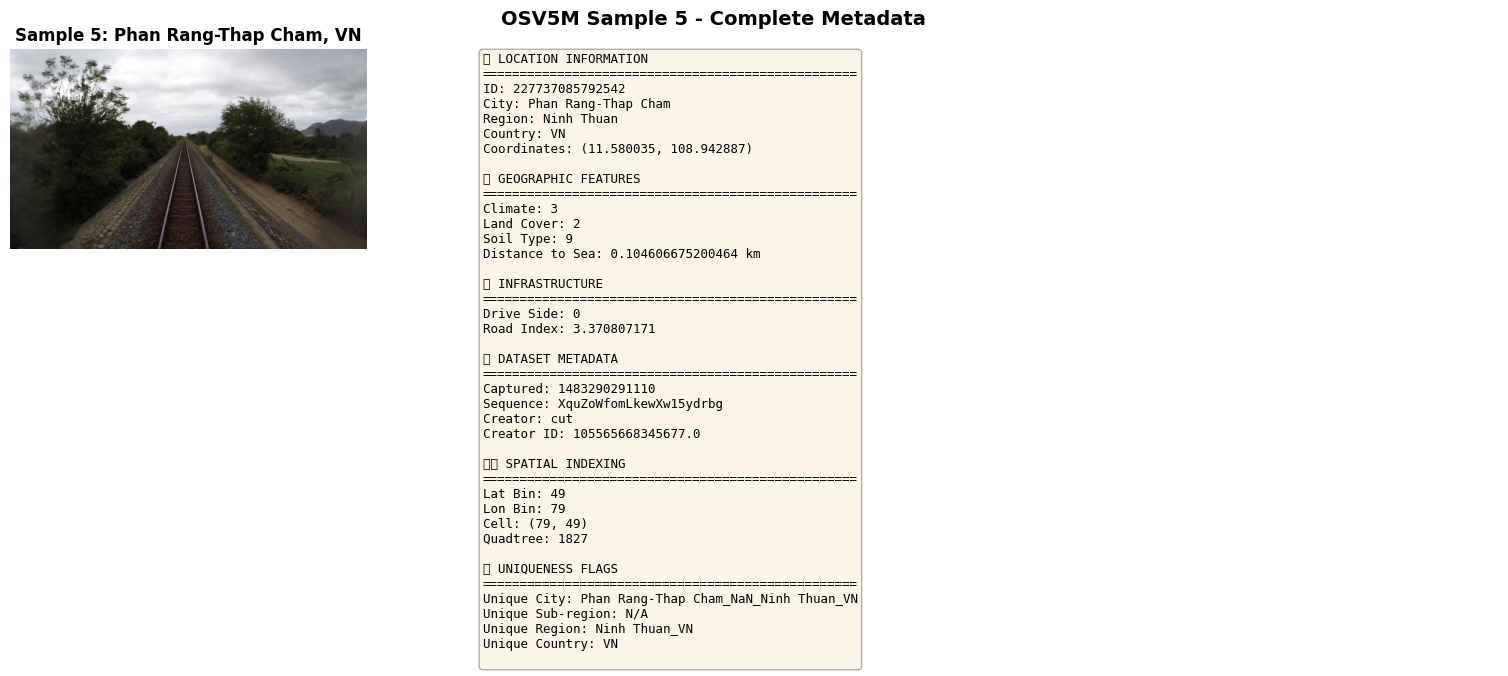


📍 LOCATION INFORMATION
ID: 174510417891701
City: Gul'cha
Region: Osh
Country: KG
Coordinates: (39.679820, 72.921363)

🌍 GEOGRAPHIC FEATURES
Climate: 19
Land Cover: 9
Soil Type: 5
Distance to Sea: 0.999999993311808 km

🚗 INFRASTRUCTURE
Drive Side: 0
Road Index: 2.650644302

📊 DATASET METADATA
Captured: 1566391061000
Sequence: pJzXWgBCY0EuqZAi7eFvNx
Creator: vbombaerts
Creator ID: 103823201859432.0

🗺️ SPATIAL INDEXING
Lat Bin: 70
Lon Bin: 69
Cell: (69, 70)
Quadtree: 7382

🔍 UNIQUENESS FLAGS
Unique City: Gul'cha_NaN_Osh_KG
Unique Sub-region: N/A
Unique Region: Osh_KG
Unique Country: KG

id                                                      174510417891701
latitude                                                       39.67982
longitude                                                     72.921363
thumb_original_url    https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...
country                                                              KG
sequence                                       

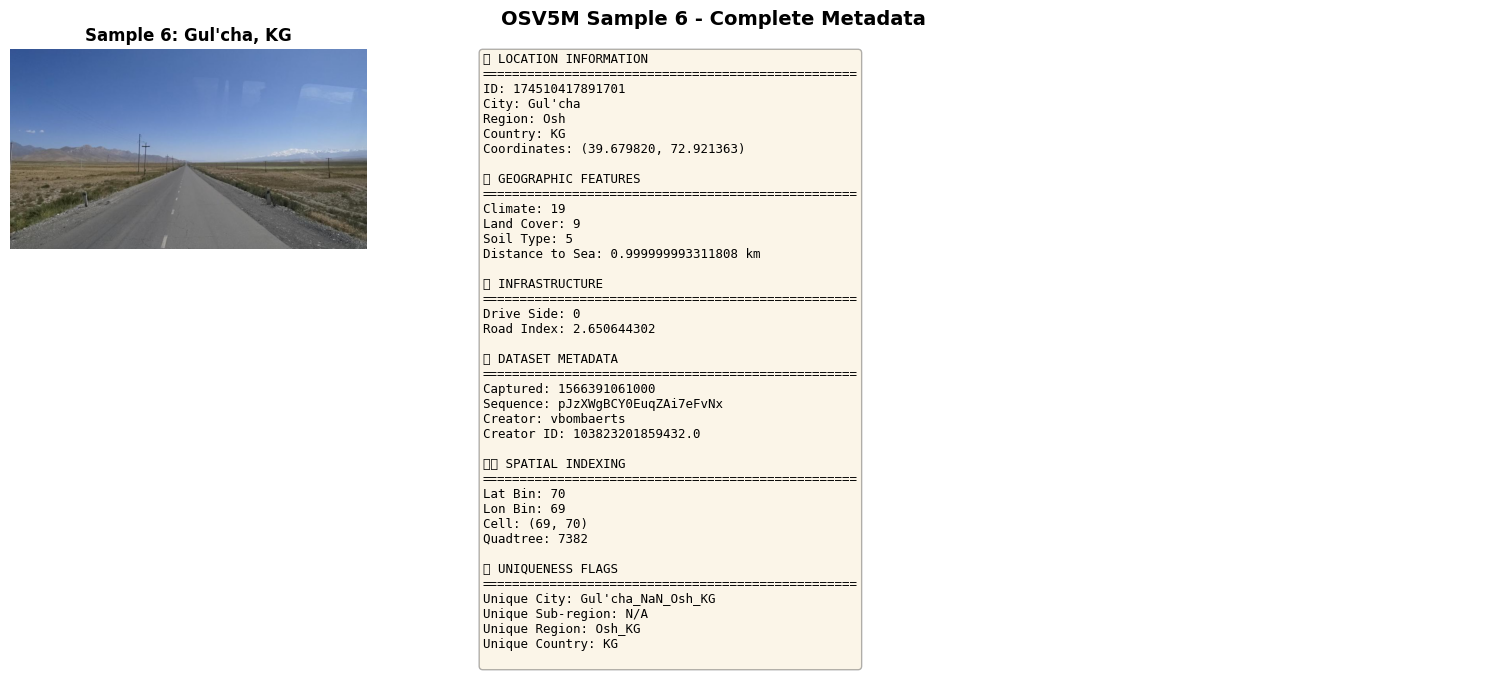

In [17]:
# Display sample images with complete metadata
if available_samples:
    # Show detailed view for each sample with all metadata
    for idx, sample in enumerate(available_samples[:6]):  # Show first 6 samples
        fig, (ax_img, ax_text) = plt.subplots(1, 2, figsize=(16, 5), 
                                               gridspec_kw={'width_ratios': [1, 2]})
        
        # Load and display image
        img = Image.open(sample['path'])
        data = sample['data']
        
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Sample {idx+1}: {data['city']}, {data['country']}", 
                         fontsize=12, fontweight='bold')
        
        # Display all metadata fields
        ax_text.axis('off')
        
        # Organize metadata into categories
        metadata_text = f"📍 LOCATION INFORMATION\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"ID: {data['id']}\n"
        metadata_text += f"City: {data['city'] if pd.notna(data['city']) else 'N/A'}\n"
        metadata_text += f"Region: {data['region'] if pd.notna(data['region']) else 'N/A'}\n"

        metadata_text += f"Country: {data['country']}\n"
        metadata_text += f"Coordinates: ({data['latitude']:.6f}, {data['longitude']:.6f})\n"
        
        metadata_text += f"\n🌍 GEOGRAPHIC FEATURES\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"Climate: {data['climate'] if pd.notna(data['climate']) else 'N/A'}\n"
        metadata_text += f"Land Cover: {data['land_cover'] if pd.notna(data['land_cover']) else 'N/A'}\n"
        metadata_text += f"Soil Type: {data['soil'] if pd.notna(data['soil']) else 'N/A'}\n"
        metadata_text += f"Distance to Sea: {data['dist_sea'] if pd.notna(data['dist_sea']) else 'N/A'} km\n"
        
        metadata_text += f"\n🚗 INFRASTRUCTURE\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"Drive Side: {data['drive_side'] if pd.notna(data['drive_side']) else 'N/A'}\n"
        metadata_text += f"Road Index: {data['road_index'] if pd.notna(data['road_index']) else 'N/A'}\n"
        
        metadata_text += f"\n📊 DATASET METADATA\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"Captured: {data['captured_at'] if pd.notna(data['captured_at']) else 'N/A'}\n"
        metadata_text += f"Sequence: {data['sequence'] if pd.notna(data['sequence']) else 'N/A'}\n"
        metadata_text += f"Creator: {data['creator_username'] if pd.notna(data['creator_username']) else 'N/A'}\n"
        metadata_text += f"Creator ID: {data['creator_id'] if pd.notna(data['creator_id']) else 'N/A'}\n"
        
        metadata_text += f"\n🗺️ SPATIAL INDEXING\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"Lat Bin: {data['lat_bin'] if pd.notna(data['lat_bin']) else 'N/A'}\n"
        metadata_text += f"Lon Bin: {data['lon_bin'] if pd.notna(data['lon_bin']) else 'N/A'}\n"
        metadata_text += f"Cell: {data['cell'] if pd.notna(data['cell']) else 'N/A'}\n"
        metadata_text += f"Quadtree: {data['quadtree_10_1000'] if pd.notna(data['quadtree_10_1000']) else 'N/A'}\n"
        
        metadata_text += f"\n🔍 UNIQUENESS FLAGS\n"
        metadata_text += f"{'='*50}\n"
        metadata_text += f"Unique City: {data['unique_city'] if pd.notna(data['unique_city']) else 'N/A'}\n"
        metadata_text += f"Unique Sub-region: {data['unique_sub-region'] if pd.notna(data['unique_sub-region']) else 'N/A'}\n"
        metadata_text += f"Unique Region: {data['unique_region'] if pd.notna(data['unique_region']) else 'N/A'}\n"
        metadata_text += f"Unique Country: {data['unique_country'] if pd.notna(data['unique_country']) else 'N/A'}\n"
        
        print(metadata_text)
        print(data)
        
        # Display the metadata text with monospace font
        ax_text.text(0.02, 0.98, metadata_text, transform=ax_text.transAxes,
                    fontsize=9, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f"OSV5M Sample {idx+1} - Complete Metadata", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        if idx < len(available_samples) - 1:
            print("")  # Add spacing between samples
        
else:
    print("No images available to display")

In [18]:
# Alternative: Compact tabular view of all metadata for available samples
if available_samples:
    print("📋 Complete Metadata Table for Available Samples\n" + "="*100)
    
    # Convert sample data to DataFrame for nice display
    sample_data_list = [sample['data'] for sample in available_samples[:6]]
    samples_df = pd.DataFrame(sample_data_list)
    
    # Display as styled table with better formatting
    styled = samples_df.style.format({
        'latitude': '{:.4f}',
        'longitude': '{:.4f}',
        'dist_sea': '{:.1f}',
        'road_index': '{:.2f}',
        'lat_bin': '{:.2f}',
        'lon_bin': '{:.2f}'
    }, na_rep='N/A')
    
    # Show transposed view for better readability
    print("\n🔍 Detailed view (transposed for readability):")
    for i, sample in enumerate(available_samples[:3]):
        print(f"\n{'='*50}")
        print(f"SAMPLE {i+1}: {sample['data']['city']}, {sample['data']['country']}")
        print(f"{'='*50}")
        sample_series = pd.Series(sample['data'])
        for key, value in sample_series.items():
            if pd.notna(value):
                print(f"{key:25s}: {value}")
    
    # Create summary statistics table
    print(f"\n\n📊 Summary Statistics for Available Samples")
    print("="*100)
    numeric_cols = ['latitude', 'longitude', 'dist_sea', 'road_index']
    summary_stats = samples_df[numeric_cols].describe()
    print(summary_stats.to_string())

📋 Complete Metadata Table for Available Samples

🔍 Detailed view (transposed for readability):

SAMPLE 1: Panagar, IN
id                       : 2057366217739411
latitude                 : 23.274160447553
longitude                : 79.986495247249
thumb_original_url       : https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/An_bOuZNH0Mm4HvBM4Dx70E3ZmON_2fizBCIVh_Drx1FDNsJEuJleLdD84UvCIgvt0UlbLFTEZZnF3luK0sUAF2l59xVgmd3bgr-RQ8XvUrW9FvRXykPax_WD2q0g7HIP2jcqFctAgxF_AhTPATsLGs?ccb=10-5&oh=00_AfCAqjaRbmccoZ50TJyZIkz5EapbB8EuJiyzI_uTtU0-Ng&oe=650F18E6&_nc_sid=201bca
country                  : IN
sequence                 : 0Nrt1Dlwz-lYCa2qnIfhAQ
captured_at              : 1506705857000
lon_bin                  : 71
lat_bin                  : 57
cell                     : (71, 57)
land_cover               : 2
road_index               : 4.311433792
drive_side               : 1
climate                  : 3
soil                     : 3
dist_sea                 : 0.9999970070423776
region               

## 5. Environment Prediction Modes

The OSV5M environment supports different difficulty levels:

In [19]:
# Demonstrate the different prediction modes and prompts
# in a notebook cell
import sys
sys.path.insert(0, "/home/sdan/workspace/octsix_vlmrl")          # repo-root layout
sys.path.insert(0, "/home/sdan/workspace/octsix_vlmrl/src")      # src/ layout (try this if the above fails)

# Show the different prompt templates
prediction_modes = {
    "country": "Predict the country (2-letter code)",
    "region": "Predict the region/state and country",
    "city": "Predict the city and country",
    "coords": "Predict city, region, country, and coordinates"
}

print("🎯 Prediction Modes\n" + "="*50)
for mode, description in prediction_modes.items():
    print(f"\n📍 {mode.upper()} Mode:")
    print(f"   Task: {description}")
    
# Create example prompts
print("\n\n📝 Example Prompts\n" + "="*50)

prompt_templates = {
    "country": "Provide your best guess for the location. Respond using the labels below.\nCountry:",
    "region": "Provide your best guess for the location. Respond using the labels below.\nRegion:\nCountry:",
    "city": "Provide your best guess for the location. Respond using the labels below.\nCity:\nCountry:",
    "coords": "Provide your best guess for the location. Respond using the labels below.\nCity:\nRegion:\nCountry:\nLatitude:\nLongitude:"
}

for mode, template in prompt_templates.items():
    print(f"\n{mode.upper()} mode prompt:")
    print("  " + template.replace("\n", "\n  "))

🎯 Prediction Modes

📍 COUNTRY Mode:
   Task: Predict the country (2-letter code)

📍 REGION Mode:
   Task: Predict the region/state and country

📍 CITY Mode:
   Task: Predict the city and country

📍 COORDS Mode:
   Task: Predict city, region, country, and coordinates


📝 Example Prompts

COUNTRY mode prompt:
  Provide your best guess for the location. Respond using the labels below.
  Country:

REGION mode prompt:
  Provide your best guess for the location. Respond using the labels below.
  Region:
  Country:

CITY mode prompt:
  Provide your best guess for the location. Respond using the labels below.
  City:
  Country:

COORDS mode prompt:
  Provide your best guess for the location. Respond using the labels below.
  City:
  Region:
  Country:
  Latitude:
  Longitude:


## 7. Interactive Map Visualization

In [20]:
!pip install folium
%pip install folium
# Create an interactive map with sample locations
if FOLIUM_AVAILABLE and available_samples:
    # Create a map centered on world view
    m = folium.Map(location=[20, 0], zoom_start=2)
    
    # Add markers for sample images
    for sample in available_samples[:50]:  # Limit to 50 for performance
        data = sample['data']
        
        # Create popup text
        popup_text = f"""
        <b>{data['city']}</b><br>
        {data['region']}, {data['country']}<br>
        Lat: {data['latitude']:.4f}<br>
        Lon: {data['longitude']:.4f}
        """
        
        folium.Marker(
            location=[data['latitude'], data['longitude']],
            popup=folium.Popup(popup_text, max_width=200),
            tooltip=f"{data['city']}, {data['country']}"
        ).add_to(m)
    
    print("🗺️ Interactive map with sample locations:")
    display(m)
else:
    if not FOLIUM_AVAILABLE:
        print("Install folium for interactive maps: pip install folium")
    else:
        print("No sample data available for map visualization")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


NameError: name 'FOLIUM_AVAILABLE' is not defined

## 8. Sample Data Table

In [ ]:
# Show a nice formatted table of sample data
sample_df = df.sample(n=min(15, len(df)), random_state=42)
display_cols = ['id', 'city', 'region', 'country', 'latitude', 'longitude']

print("📊 Random Sample of Dataset Entries\n" + "="*100)
styled_df = sample_df[display_cols].style.format({
    'latitude': '{:.4f}',
    'longitude': '{:.4f}'
})

display(styled_df)